In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
tennis <- read_csv('player_stats.csv')
colnames(tennis) <- make.names(colnames(tennis))

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [70]:
tennis_data <- tennis |>
filter(Active == "Yes") |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Best.Rank, into = c("Best.Rank", "Best.Rank.Date"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
separate(col = Best.Elo.Rank, into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"), sep = " ") |>
separate(col = Peak.Elo.Rating, into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"), sep = " ") |>
mutate(Current.Rank = as.numeric(Current.Rank), Current.Elo.Rank = as.numeric(Current.Elo.Rank),
       Best.Elo.Rank = as.numeric(Best.Elo.Rank), Peak.Elo.Rating = as.numeric(Peak.Elo.Rating), Best.Rank = as.numeric(Best.Rank),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prev.Rank = as.numeric(gsub("[^0-9.-]", "", Prev.Rank)),
       Money.Per.Season = Prize.Money/Seasons, Age = as.numeric(Age)) |>
select(Name, Age, Seasons, Current.Rank, Prev.Rank, Best.Rank, Current.Elo.Rank, Current.Elo.Rating, Peak.Elo.Rating,
           Prize.Money, Money.Per.Season) |>
filter(!is.na(Money.Per.Season), !is.na(Age))
tennis_data_current <- tennis_data |>
filter(!is.na(Current.Rank), !is.na(Current.Elo.Rating))
tennis_data_best <- tennis_data |>
filter(!is.na(Peak.Elo.Rating), !is.na(Best.Rank))
tennis_data_rank <- tennis_data |>
filter(!is.na(Current.Rank), !is.na(Best.Rank), !is.na(Prev.Rank))
tennis_data_all <- tennis_data |>
filter(!is.na(Current.Rank), !is.na(Current.Elo.Rating), !is.na(Best.Rank), !is.na(Peak.Elo.Rating), !is.na(Prev.Rank))
tennis_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Name,Age,Seasons,Current.Rank,Prev.Rank,Best.Rank,Current.Elo.Rank,Current.Elo.Rating,Peak.Elo.Rating,Prize.Money,Money.Per.Season
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,14,178,280,44,144,1764,1886,3261567,232969.1
Duck Hee Lee,21,2,236,199,130,NA,NA,NA,374093,187046.5
Bernard Tomic,27,11,183,273,17,100,1826,2037,6091971,553815.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Mirza Basic,28,7,292,138,74,143,1764,1904,1048314,149759.14
Dimitar Kuzmanov,26,8,324,120,249,180,1679,1679,132871,16608.88
Artem Dubrivnyy,20,1,397,89,394,NA,NA,NA,40724,40724.00


In [71]:
set.seed(16)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

Below is a table organizing the players by number of active seasons, and giving the mean values for potential predicotr variables. Additionally, we included a table containing the amount of missing values for each predictor variable over our training set.

In [72]:
players_by_seasons <- tennis_training |>
    group_by(Seasons) |>
    summarize(count = n(), Mean.Best.Rank = mean(Best.Rank,na.rm = TRUE), Mean.Peak.Rating = mean(Peak.Elo.Rating,na.rm = TRUE),
              Mean.Current.Rank = mean(Current.Rank, na.rm = TRUE), Mean.Current.Rating = mean(Current.Elo.Rating, na.rm = TRUE))
missing_tennis_data <- tennis_training |>
    summarize(Active.Players = n(),
              Missing.Best.Rank = sum(is.na(Best.Rank)),
              Missing.Current.Rank = sum(is.na(Current.Rank)),
              Missing.Prev.Rank = sum(is.na(Prev.Rank)),
              Missing.Peak.Elo = sum(is.na(Peak.Elo.Rating)),
              Missing.Current.Elo = sum(is.na(Current.Elo.Rating)),
              Missing.Age = sum(is.na(Age)))
players_by_seasons
missing_tennis_data

Seasons,count,Mean.Best.Rank,Mean.Peak.Rating,Mean.Current.Rank,Mean.Current.Rating
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,11,330.2727,NaN,352.0000,NaN
2,23,198.8261,1792.00,246.1304,1784.000
3,23,121.5217,1851.25,163.0435,1829.273
⋮,⋮,⋮,⋮,⋮,⋮
19,1,1.0,2552,1.0,2406
20,2,25.5,2016,157.5,1846
21,1,5.0,2106,200.0,NaN


Active.Players,Missing.Best.Rank,Missing.Current.Rank,Missing.Prev.Rank,Missing.Peak.Elo,Missing.Current.Elo,Missing.Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
192,0,0,0,52,73,0


Below are some plots visualizing the relationships between potential predictor variables and Prize Money, or Prize Money per Season.
Due to being an extreme outlier in terms of Prize Money, for visualization purposes we have removed Rafael Nadal from the data set. We still plan to use him in our model.

In [73]:
tennis_data_for_viz <- tennis_training |>
    filter(Name != "Rafael Nadal")

$title
[1] "Seasons vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Seasons vs Money per Seasons"

attr(,"class")
[1] "labels"

$title
[1] "Age vs Money Per Season"

attr(,"class")
[1] "labels"

$title
[1] "Peak Elo Rating vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Best Rank vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Current Elo vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Current Elo Rating"

attr(,"class")
[1] "labels"

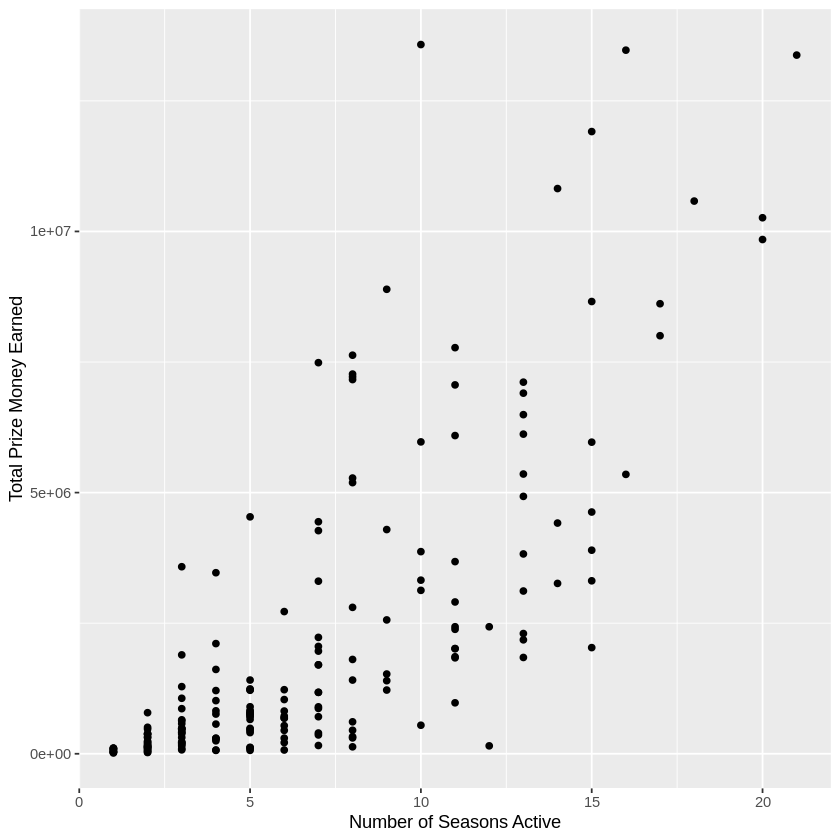

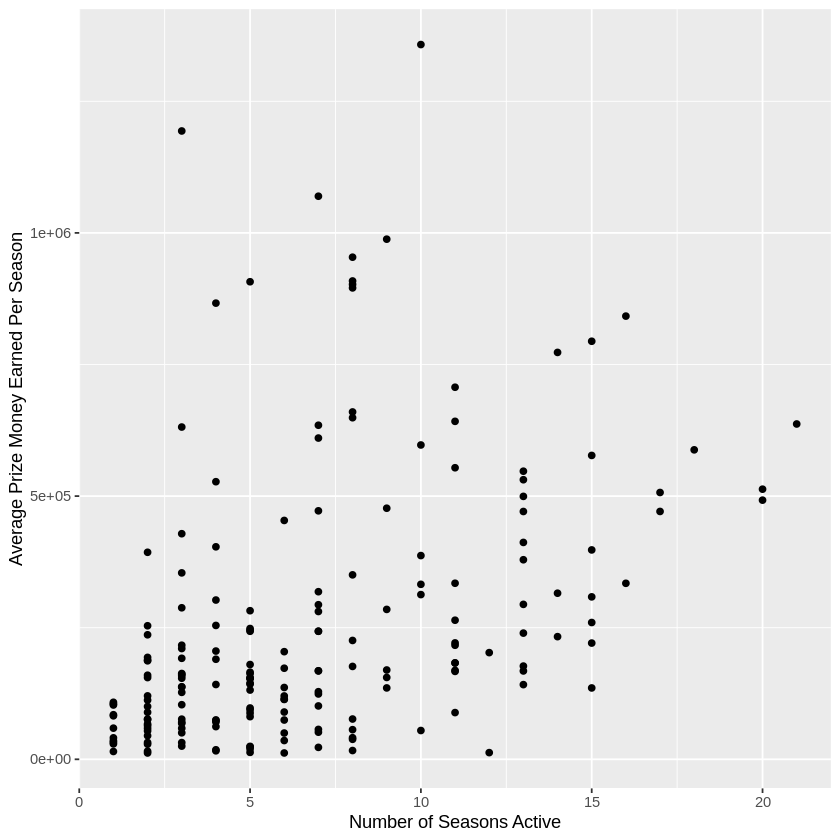

Warning message:
“Removed 52 rows containing missing values (geom_point).”


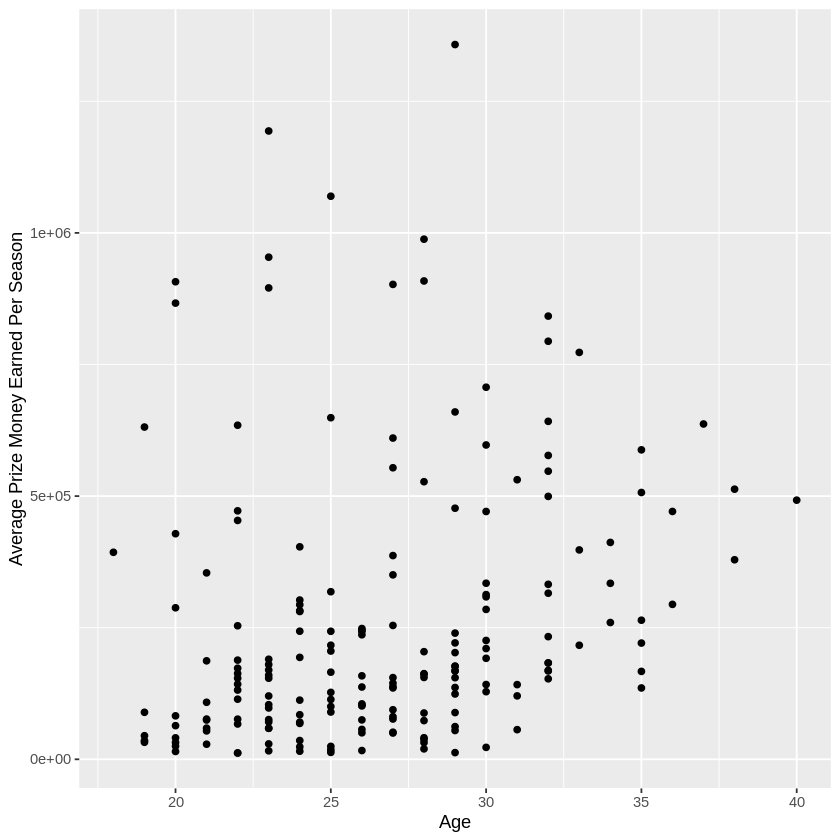

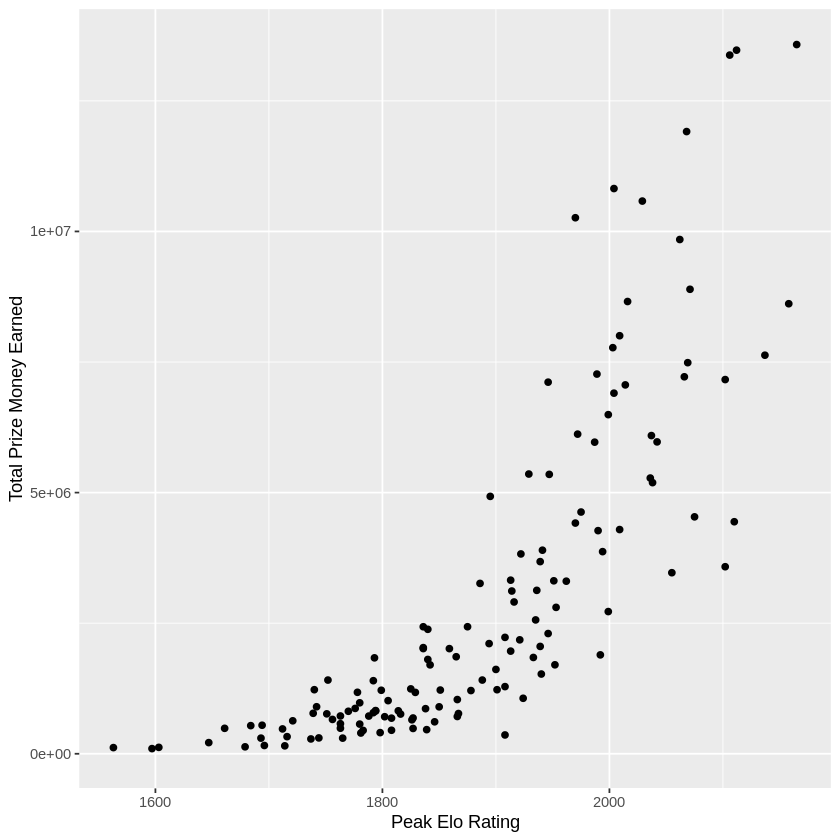

Warning message:
“Removed 73 rows containing missing values (geom_point).”


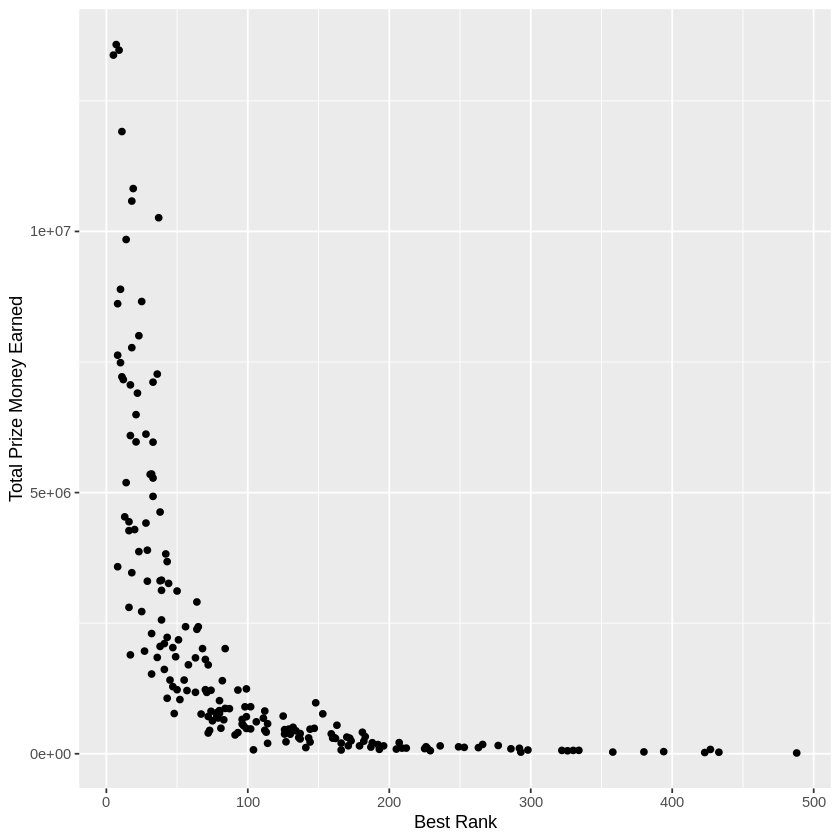

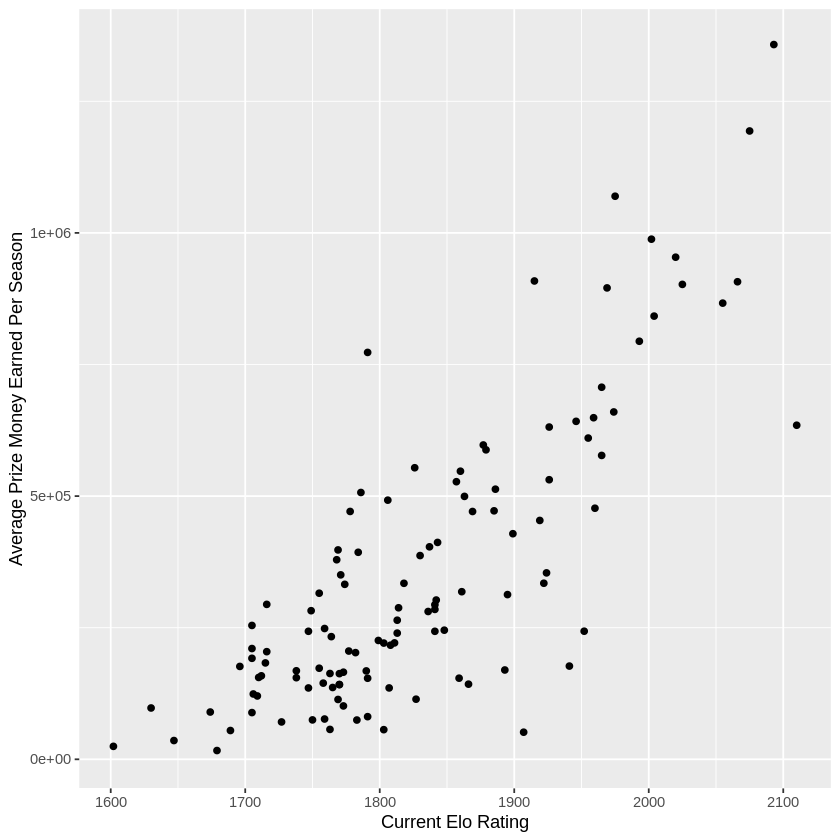

Warning message:
“Removed 73 rows containing missing values (geom_point).”


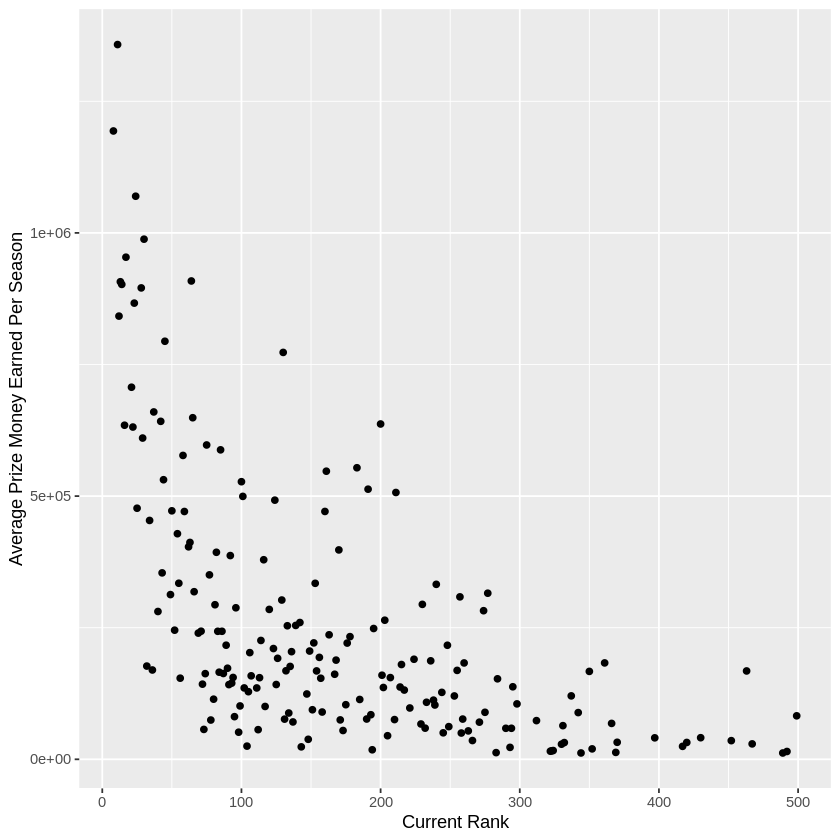

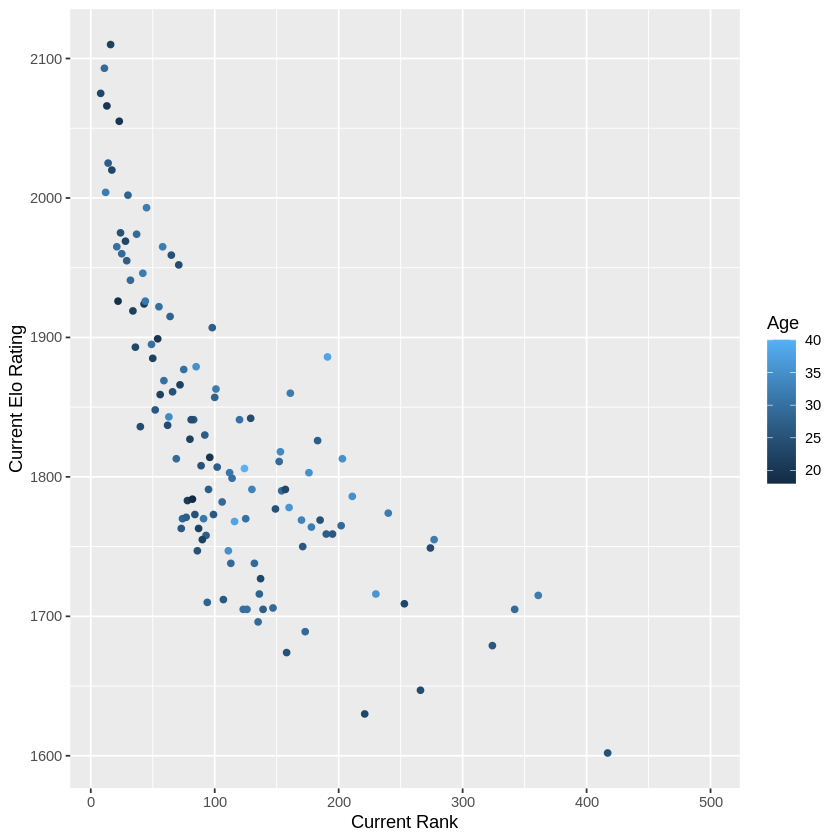

In [74]:
tennis_plot_seasons <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Prize.Money)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Total Prize Money Earned")
    ggtitle("Seasons vs Prize Money")
tennis_plot_money_per_season <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Average Prize Money Earned Per Season")
    ggtitle("Seasons vs Money per Seasons")
tennis_plot_age <- tennis_data_for_viz |>
    ggplot(aes(x = Age, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Age", y = "Average Prize Money Earned Per Season")
    ggtitle("Age vs Money Per Season")
tennis_plot_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Peak.Elo.Rating, y = Prize.Money)) +
    geom_point() +
    labs(x = "Peak Elo Rating", y  = "Total Prize Money Earned")
    ggtitle("Peak Elo Rating vs Prize Money")
tennis_plot_rank <- tennis_data_for_viz |>
    ggplot(aes(x = Best.Rank, y = Prize.Money)) +
    geom_point() +
    labs(x = "Best Rank", y = "Total Prize Money Earned")
    ggtitle("Best Rank vs Prize Money")
tennis_plot_elo_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Elo Rating", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Elo vs Money per Year")
tennis_plot_rank_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Rank", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Rank vs Money per Year")
tennis_plot_current_rank_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Current.Elo.Rating, color = Age)) +
    geom_point() +
    labs(x = "Current Rank", y = "Current Elo Rating")
    ggtitle("Current Rank vs Current Elo Rating")
tennis_plot_seasons
tennis_plot_money_per_season
tennis_plot_age
tennis_plot_elo
tennis_plot_rank
tennis_plot_elo_perYear
tennis_plot_rank_perYear
tennis_plot_current_rank_elo

Data_analysis

In [75]:
tennis_test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
ks <- tibble(neighbors = seq(1,15))


Analysis using Current Elo and Current Rank as a predictor value

[1] 3

[1] 323796.8

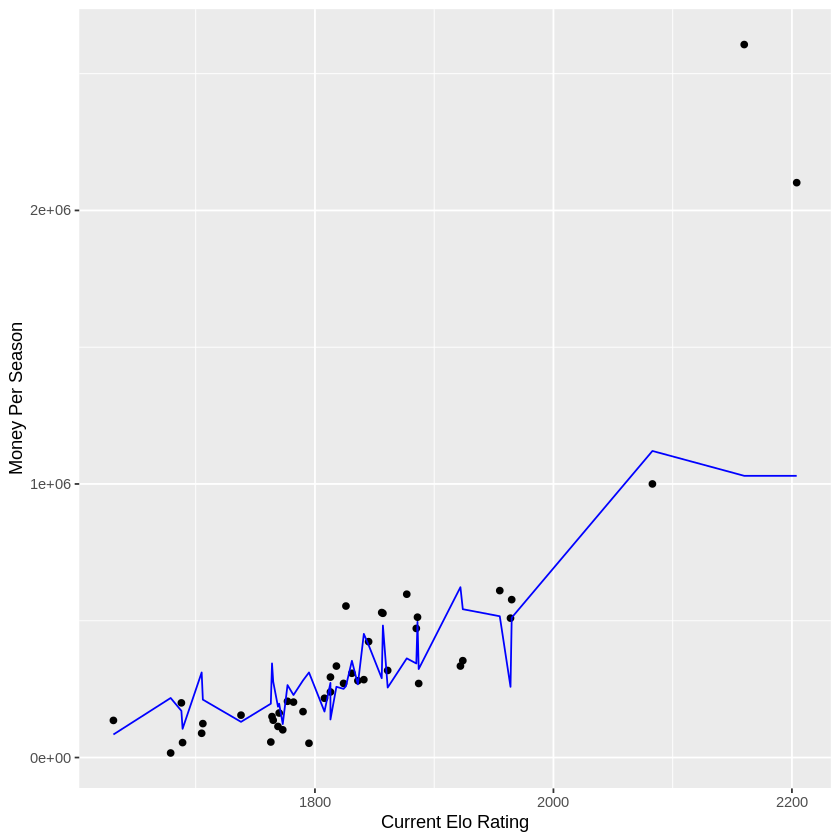

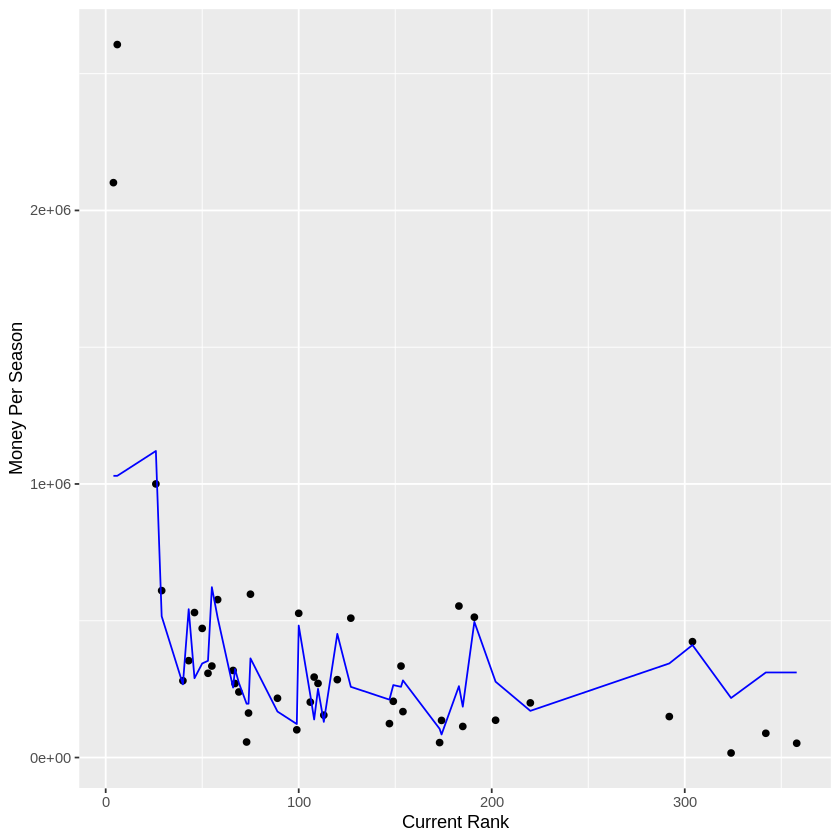

In [76]:
set.seed(16)
tennis_split_current <- initial_split(tennis_data_current, prop = 0.75, strata = Money.Per.Season)
tennis_training_current <- training(tennis_split_current)
tennis_testing_current <- testing(tennis_split_current)
tennis_vfold_current <- vfold_cv(tennis_training_current, v = 5, strata = Money.Per.Season)

tennis_recipe_current <- recipe(Money.Per.Season ~ Current.Rank + Current.Elo.Rating, data = tennis_training)

tennis_workflow_current <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_current)
tennis_results_current <- tennis_workflow_current |>
    tune_grid(resamples = tennis_vfold, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_current <- tennis_results_current |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_current <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_current <- workflow() |>
    add_model(tennis_spec_current) |>
    add_recipe(tennis_recipe_current) |>
    fit(tennis_training_current)
tennis_preds_current <- predict(tennis_fit_current, tennis_testing_current) |>
    bind_cols(tennis_testing_current)
tennis_metric_current <- tennis_preds_current |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_rank_current <- tennis_preds_current |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_current,
              mapping = aes(x = Current.Rank, y = .pred),
              color = "blue") +
    labs(x = "Current Rank", y = "Money Per Season")
tennis_plot_elo_current <- tennis_preds_current |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_current,
              mapping = aes(x = Current.Elo.Rating, y = .pred),
              color = "blue") +
    labs(x = "Current Elo Rating", y = "Money Per Season")
k_min_current
tennis_metric_current
tennis_plot_elo_current
tennis_plot_rank_current


Analysis using Age, Current Rank, and Current elo as predictor values

[1] 4

[1] 348070.5

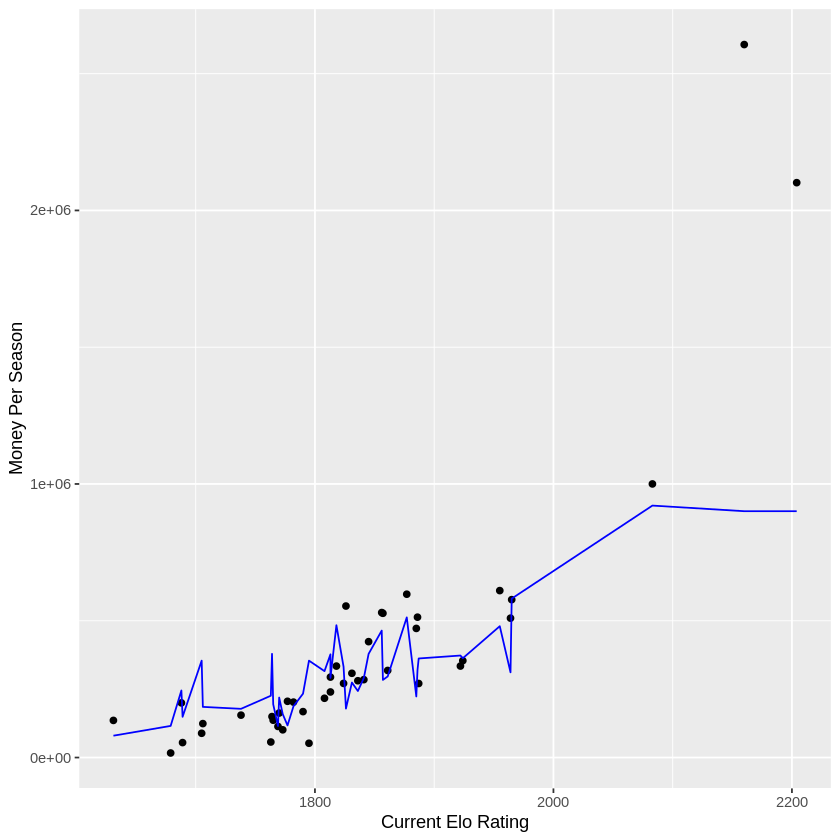

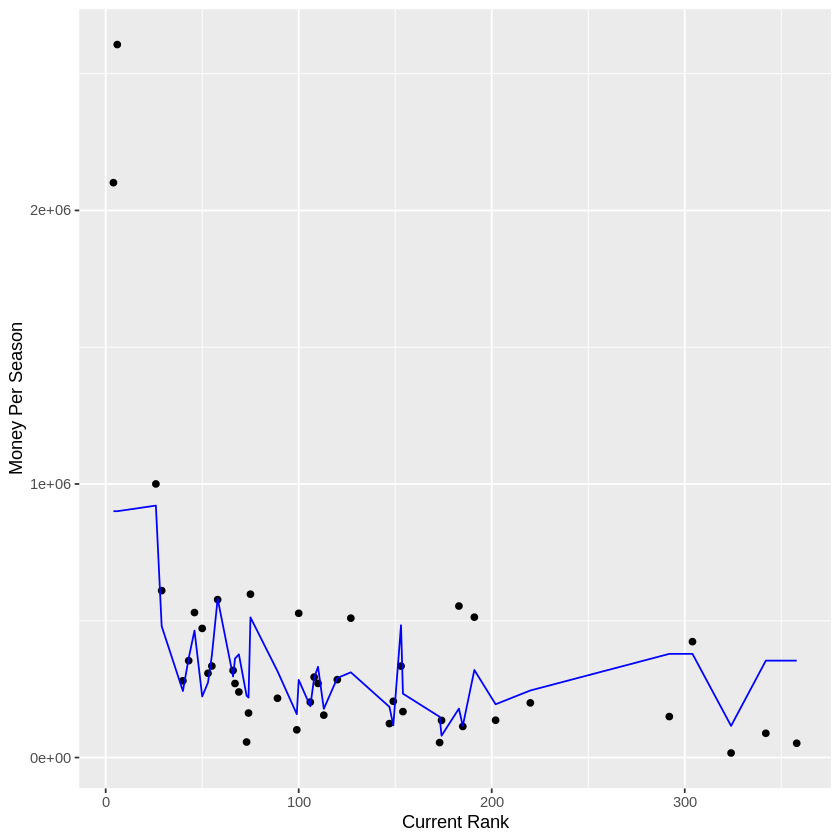

In [77]:
tennis_recipe_age <- recipe(Money.Per.Season ~ Age + Current.Rank + Current.Elo.Rating, data = tennis_training_current)

tennis_workflow_age <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_age)
tennis_results_age <- tennis_workflow_age |>
    tune_grid(resamples = tennis_vfold, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_age <- tennis_results_age |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_age) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_age <- workflow() |>
    add_model(tennis_spec_age) |>
    add_recipe(tennis_recipe_age) |>
    fit(tennis_training_current)
tennis_preds_age <- predict(tennis_fit_age, tennis_testing_current) |>
    bind_cols(tennis_testing_current)
tennis_metric_age <- tennis_preds_age |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_rank_age <- tennis_preds_age |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_age,
              mapping = aes(x = Current.Rank, y = .pred),
              color = "blue") +
    labs(x = "Current Rank", y = "Money Per Season")
tennis_plot_elo_age <- tennis_preds_age |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_age,
              mapping = aes(x = Current.Elo.Rating, y = .pred),
              color = "blue") +
    labs(x = "Current Elo Rating", y = "Money Per Season")
k_min_age
tennis_metric_age
tennis_plot_elo_age
tennis_plot_rank_age

Analysis using best rank and best elo

[1] 13

[1] 206417.5

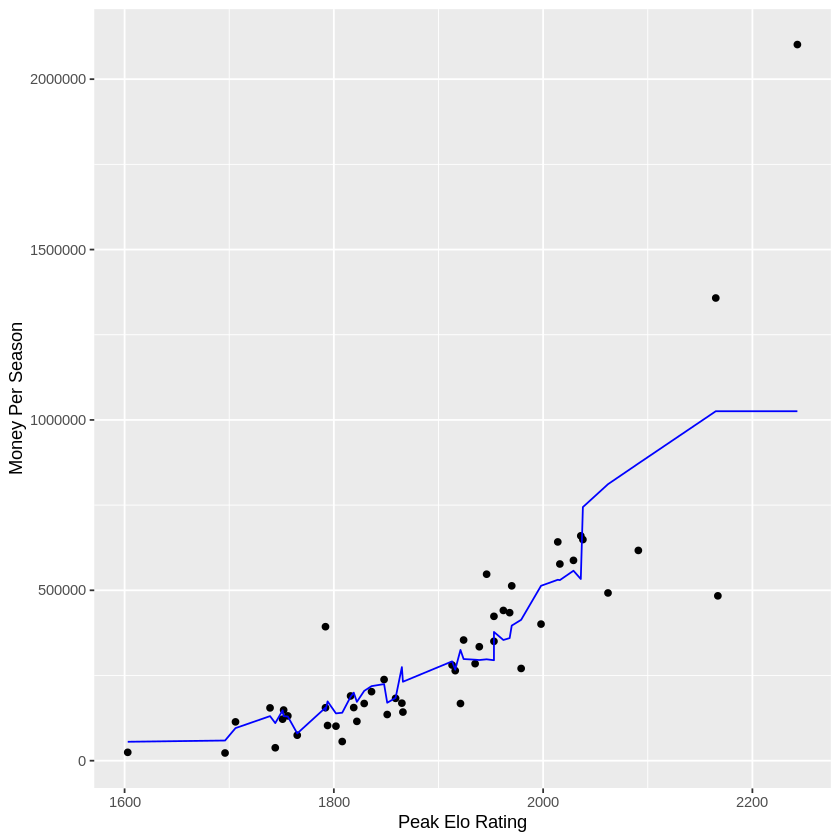

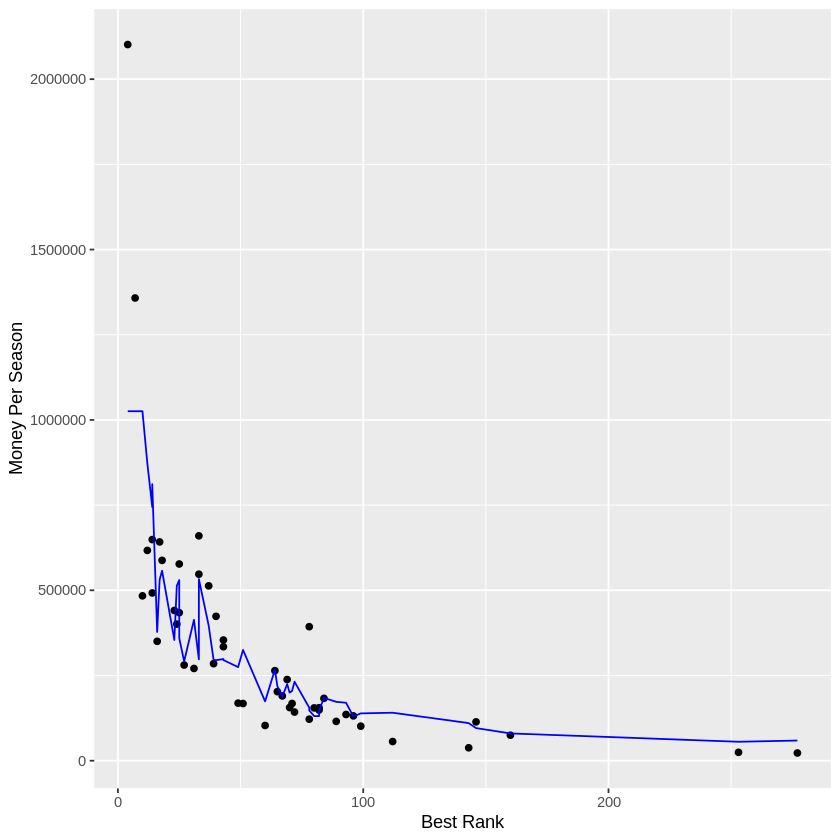

In [78]:
set.seed(16)

tennis_split_best <- initial_split(tennis_data_best, prop = 0.75, strata = Money.Per.Season)
tennis_training_best <- training(tennis_split_best)
tennis_testing_best <- testing(tennis_split_best)
tennis_vfold_best <- vfold_cv(tennis_training_best, v = 5, strata = Money.Per.Season)
tennis_recipe_best <- recipe(Money.Per.Season ~ Best.Rank + Peak.Elo.Rating, data = tennis_training_best)

tennis_workflow_best <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_best)
tennis_results_best <- tennis_workflow_best |>
    tune_grid(resamples = tennis_vfold_best, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_best <- tennis_results_best |>
    filter(mean == min(mean)) |>
    pull(neighbors)

k_min_best
tennis_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_best) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_best <- workflow() |>
    add_model(tennis_spec_best) |>
    add_recipe(tennis_recipe_best) |>
    fit(tennis_training_best)
tennis_preds_best <- predict(tennis_fit_best, tennis_testing_best) |>
    bind_cols(tennis_testing_best)
tennis_metric_best <- tennis_preds_best |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_rank_best <- tennis_preds_best |>
    ggplot(aes(x = Best.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_best,
              mapping = aes(x = Best.Rank, y = .pred),
              color = "blue") +
    labs(x = "Best Rank", y = "Money Per Season")
tennis_plot_elo_best <- tennis_preds_best |>
    ggplot(aes(x = Peak.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_best,
              mapping = aes(x = Peak.Elo.Rating, y = .pred),
              color = "blue") +
    labs(x = "Peak Elo Rating", y = "Money Per Season")
tennis_metric_best
tennis_plot_elo_best
tennis_plot_rank_best

analysis using Best Rank, Peak elo, and Age

[1] 9

[1] 189115.1

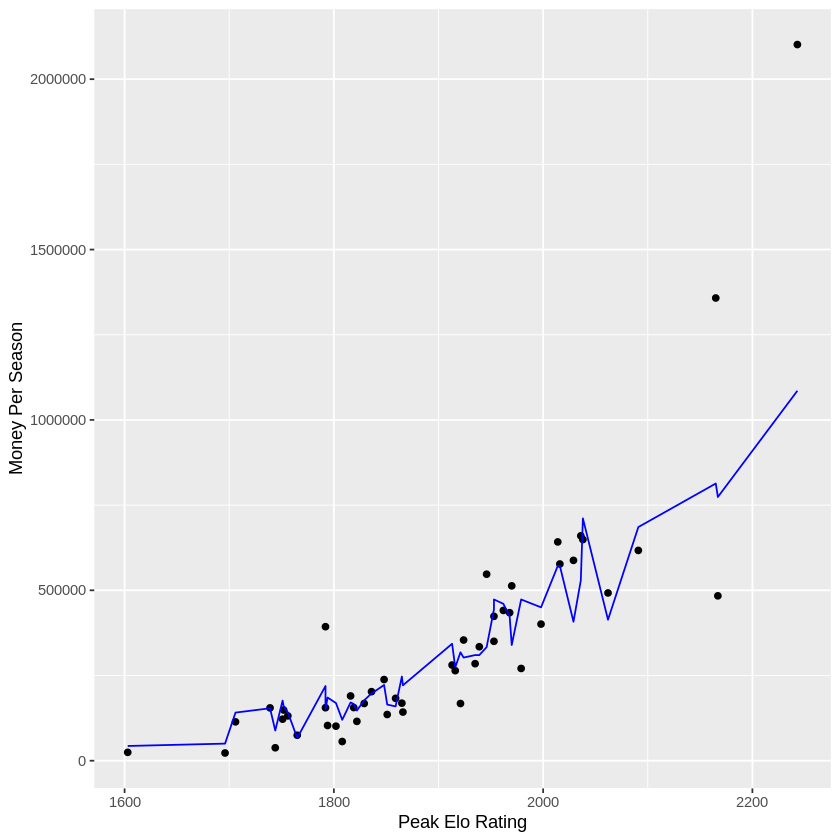

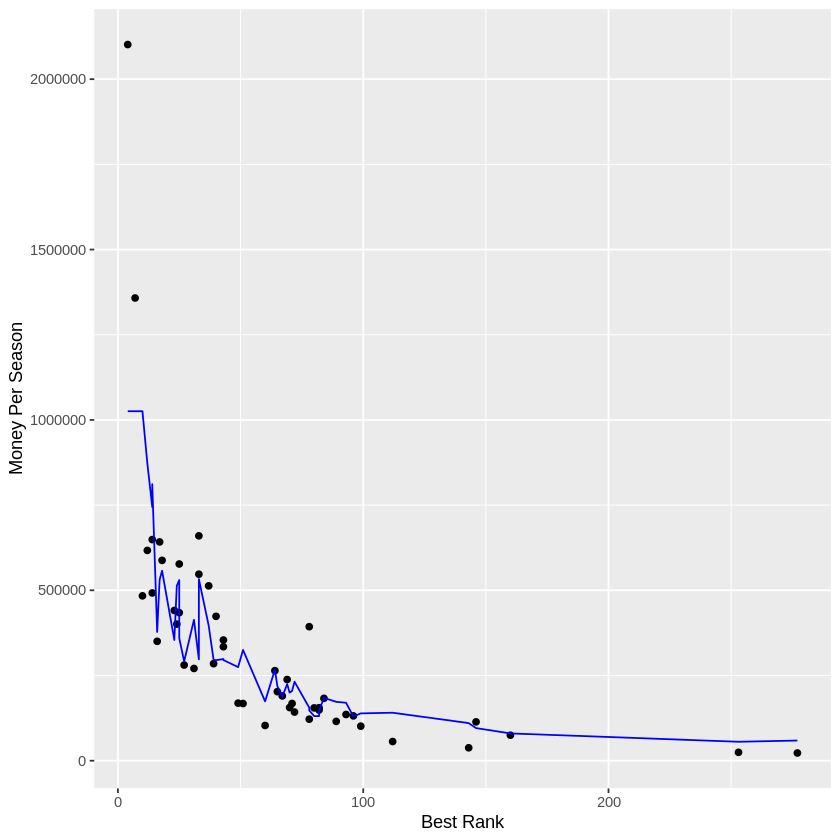

In [79]:
tennis_recipe_best_age <- recipe(Money.Per.Season ~ Age + Best.Rank + Peak.Elo.Rating, data = tennis_training_best)

tennis_workflow_best_age <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_best_age)
tennis_results_best_age <- tennis_workflow_best_age |>
    tune_grid(resamples = tennis_vfold_best, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_best_age <- tennis_results_best_age |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_best_age <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_best_age) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_best_age <- workflow() |>
    add_model(tennis_spec_best_age) |>
    add_recipe(tennis_recipe_best_age) |>
    fit(tennis_training_best)
tennis_preds_best_age <- predict(tennis_fit_best_age, tennis_testing_best) |>
    bind_cols(tennis_testing_best)
tennis_metric_best_age <- tennis_preds_best_age |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_rank_best_age <- tennis_preds_best_age |>
    ggplot(aes(x = Best.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_best,
              mapping = aes(x = Best.Rank, y = .pred),
              color = "blue") +
    labs(x = "Best Rank", y = "Money Per Season")
tennis_plot_elo_best_age <- tennis_preds_best |>
    ggplot(aes(x = Peak.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_best_age,
              mapping = aes(x = Peak.Elo.Rating, y = .pred),
              color = "blue") +
    labs(x = "Peak Elo Rating", y = "Money Per Season")

k_min_best_age
tennis_metric_best_age
tennis_plot_elo_best_age
tennis_plot_rank_best_age

Analysis using Best Rank, Current Rank, and Previous Rank

[1] 4

[1] 250875.5

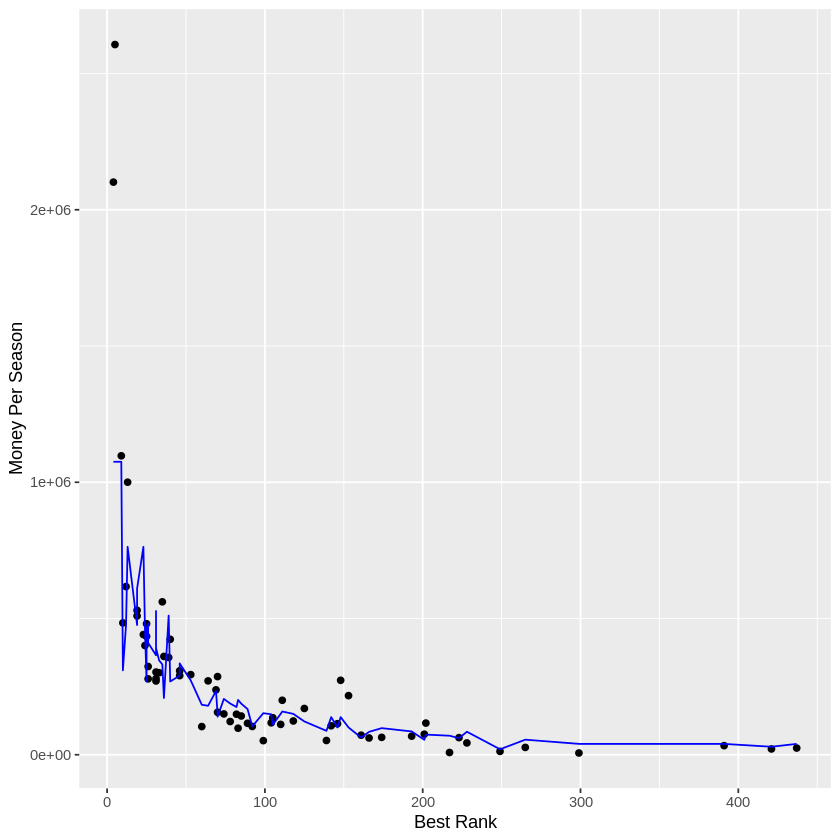

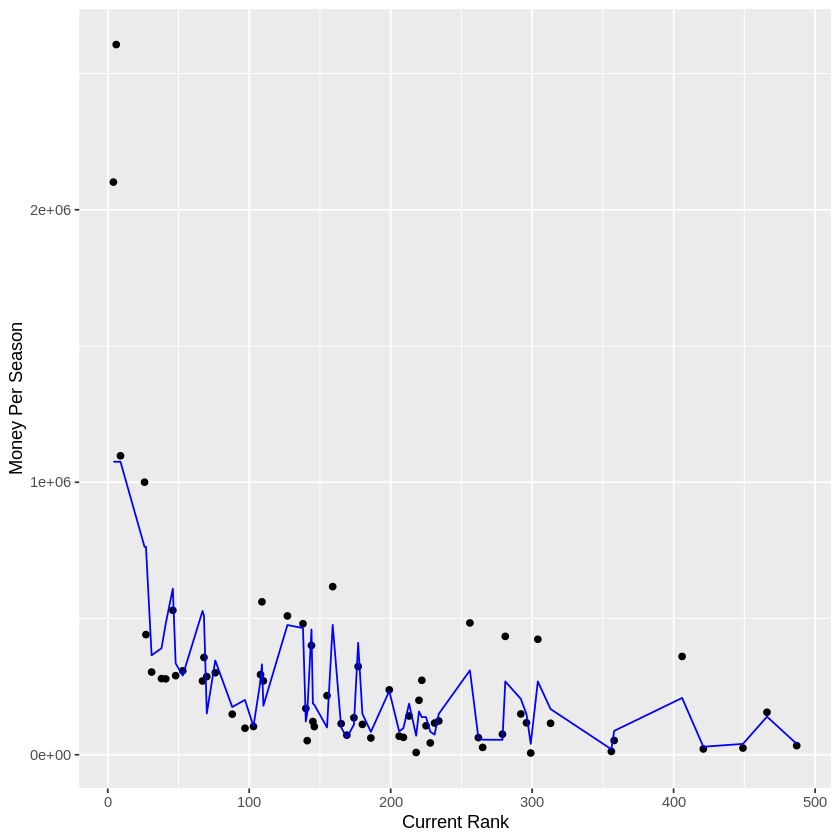

In [83]:
set.seed(16)

tennis_split_ranks <- initial_split(tennis_data_rank, prop = 0.75, strata = Money.Per.Season)
tennis_training_ranks <- training(tennis_split_ranks)
tennis_testing_ranks <- testing(tennis_split_ranks)
tennis_vfold_ranks <- vfold_cv(tennis_training_ranks, v = 5, strata = Money.Per.Season)

tennis_recipe_ranks <- recipe(Money.Per.Season ~ Best.Rank + Current.Rank + Prev.Rank, data = tennis_training_ranks)

tennis_workflow_ranks <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_ranks)
tennis_results_ranks <- tennis_workflow_ranks |>
    tune_grid(resamples = tennis_vfold_ranks, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_ranks <- tennis_results_ranks |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_ranks <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_ranks) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_ranks <- workflow() |>
    add_model(tennis_spec_ranks) |>
    add_recipe(tennis_recipe_ranks) |>
    fit(tennis_training_ranks)
tennis_preds_ranks <- predict(tennis_fit_ranks, tennis_testing_ranks) |>
    bind_cols(tennis_testing_ranks)
tennis_metric_ranks <- tennis_preds_ranks |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_best_ranks <- tennis_preds_ranks |>
    ggplot(aes(x = Best.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_ranks,
              mapping = aes(x = Best.Rank, y = .pred),
              color = "blue") +
    labs(x = "Best Rank", y = "Money Per Season")
tennis_plot_current_ranks <- tennis_preds_ranks |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_ranks,
              mapping = aes(x = Current.Rank, y = .pred),
              color = "blue") +
    labs(x = "Current Rank", y = "Money Per Season")
k_min_ranks
tennis_metric_ranks
tennis_plot_best_ranks
tennis_plot_current_ranks

Analysis using Current Rank, Best Rank, Prev Rank, and Age

[1] 5

[1] 274542.8

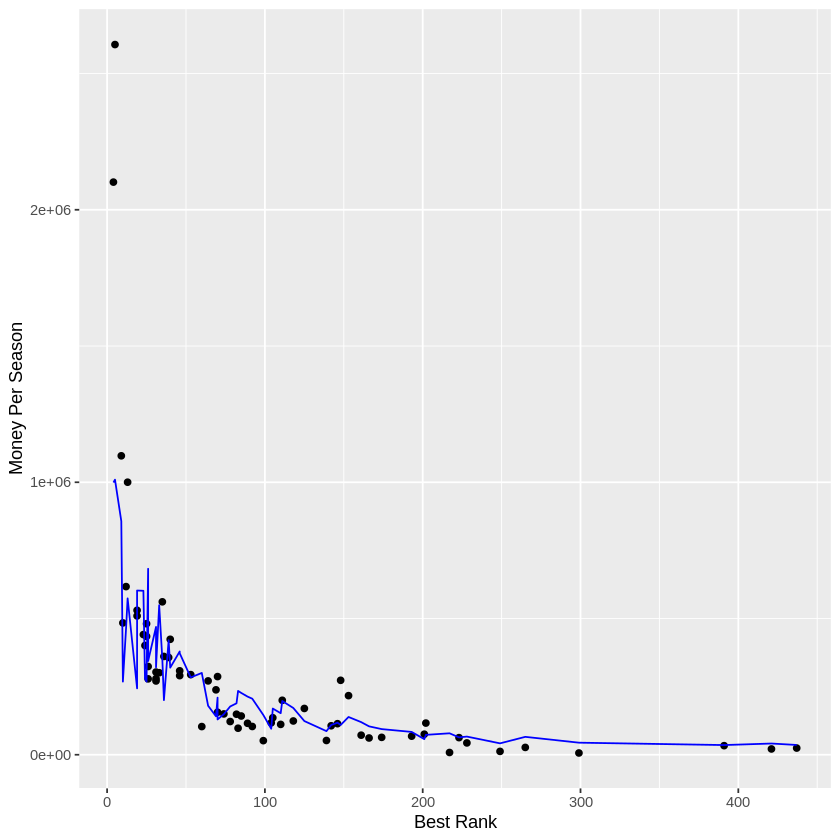

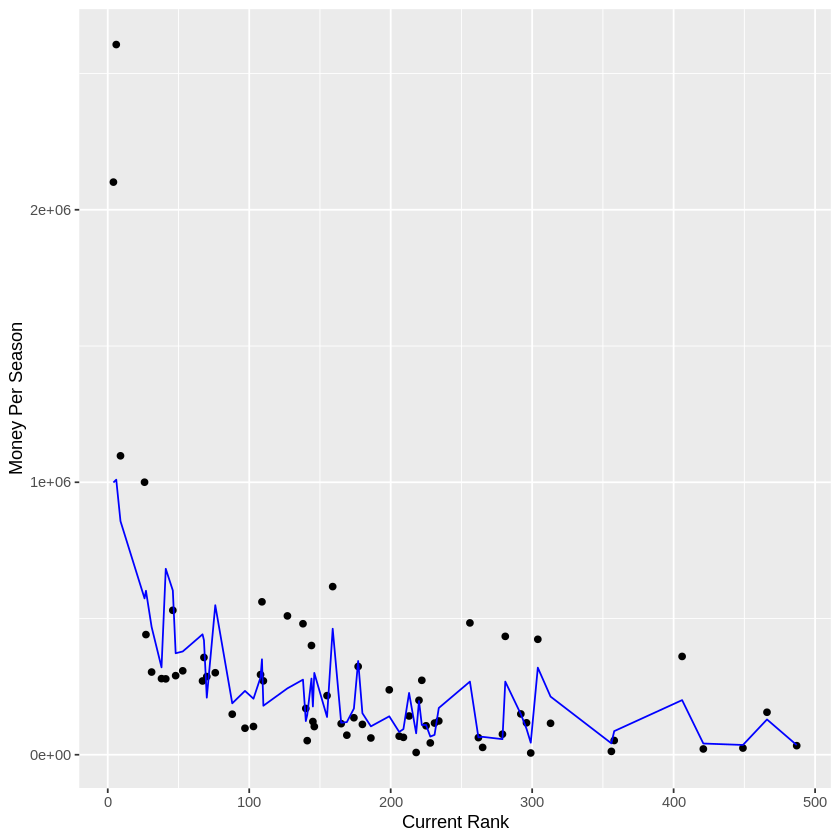

In [85]:
tennis_recipe_ranks_age <- recipe(Money.Per.Season ~ Best.Rank + Current.Rank + Prev.Rank + Age, data = tennis_training_ranks)

tennis_workflow_ranks_age <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_ranks_age)
tennis_results_ranks_age <- tennis_workflow_ranks_age |>
    tune_grid(resamples = tennis_vfold_ranks, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_ranks_age <- tennis_results_ranks_age |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_ranks_age <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_ranks_age) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_ranks_age <- workflow() |>
    add_model(tennis_spec_ranks_age) |>
    add_recipe(tennis_recipe_ranks_age) |>
    fit(tennis_training_ranks)
tennis_preds_ranks_age <- predict(tennis_fit_ranks_age, tennis_testing_ranks) |>
    bind_cols(tennis_testing_ranks)
tennis_metric_ranks_age <- tennis_preds_ranks_age |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_best_ranks_age <- tennis_preds_ranks_age |>
    ggplot(aes(x = Best.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_ranks_age,
              mapping = aes(x = Best.Rank, y = .pred),
              color = "blue") +
    labs(x = "Best Rank", y = "Money Per Season")
tennis_plot_current_ranks_age <- tennis_preds_ranks_age |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_ranks_age,
              mapping = aes(x = Current.Rank, y = .pred),
              color = "blue") +
    labs(x = "Current Rank", y = "Money Per Season")
k_min_ranks_age
tennis_metric_ranks_age
tennis_plot_best_ranks_age
tennis_plot_current_ranks_age

Analysis using all previous predictors used

[1] 3

[1] 281204.3

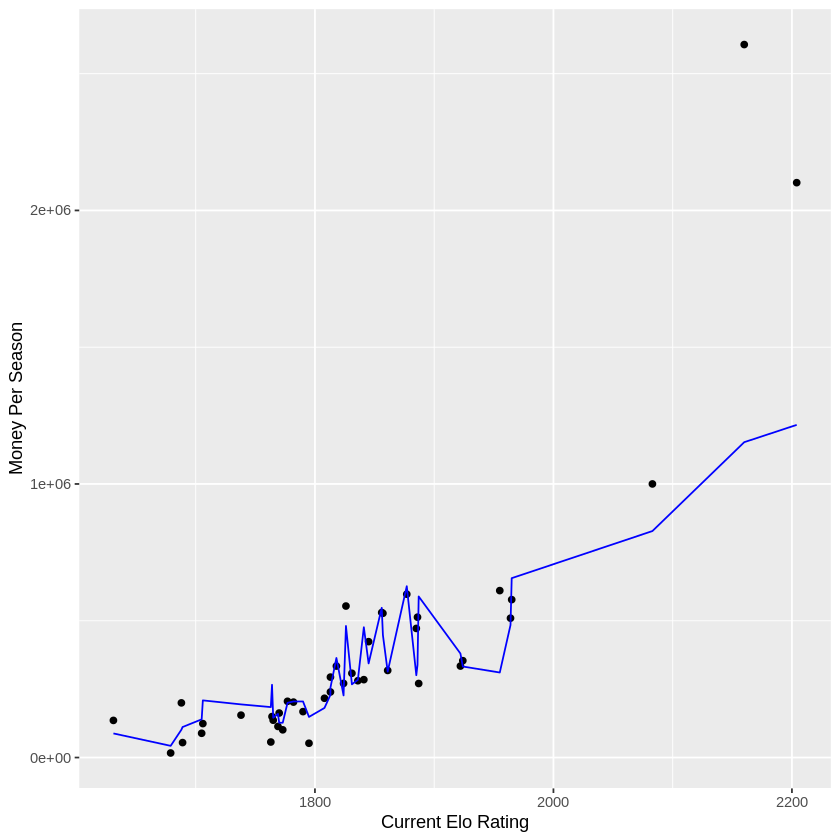

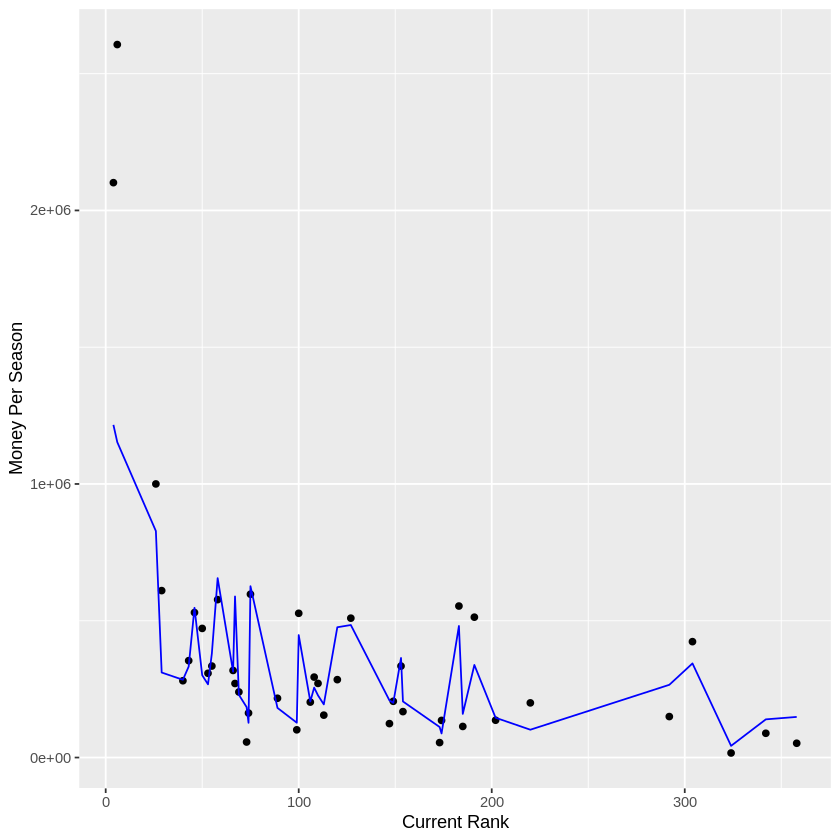

In [86]:
set.seed(16)

tennis_split_all <- initial_split(tennis_data_all, prop = 0.75, strata = Money.Per.Season)
tennis_training_all <- training(tennis_split_all)
tennis_testing_all <- testing(tennis_split_all)
tennis_vfold_all <- vfold_cv(tennis_training_all, v = 5, strata = Money.Per.Season)

tennis_recipe_all <- recipe(Money.Per.Season ~ Age + Current.Rank + Current.Elo.Rating + Best.Rank + Peak.Elo.Rating + Prev.Rank,
                            data = tennis_training_all)

tennis_workflow_all <- workflow() |>
    add_model(tennis_test_spec) |>
    add_recipe(tennis_recipe_all)
tennis_results_all <- tennis_workflow_all |>
    tune_grid(resamples = tennis_vfold_all, grid = ks) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min_all <- tennis_results_all |>
    filter(mean == min(mean)) |>
    pull(neighbors)

tennis_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_all) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_fit_all <- workflow() |>
    add_model(tennis_spec_all) |>
    add_recipe(tennis_recipe_all) |>
    fit(tennis_training_all)
tennis_preds_all <- predict(tennis_fit_all, tennis_testing_all) |>
    bind_cols(tennis_testing_all)
tennis_metric_all <- tennis_preds_all |>
    metrics(truth = Money.Per.Season, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)
tennis_plot_rank_all <- tennis_preds_all |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_all,
              mapping = aes(x = Current.Rank, y = .pred),
              color = "blue") +
    labs(x = "Current Rank", y = "Money Per Season")
tennis_plot_elo_all <- tennis_preds_all |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    geom_line(data = tennis_preds_all,
              mapping = aes(x = Current.Elo.Rating, y = .pred),
              color = "blue") +
    labs(x = "Current Elo Rating", y = "Money Per Season")
k_min_all
tennis_metric_all
tennis_plot_elo_all
tennis_plot_rank_all


Analysis of which predictors result in the best predictions

predictors,rmse
<chr>,<dbl>
Best.w.Age,189115.1
Best,206417.5
Ranks,250875.5
⋮,⋮
All,281204.3
Current,323796.8
Current.w.Age,348070.5


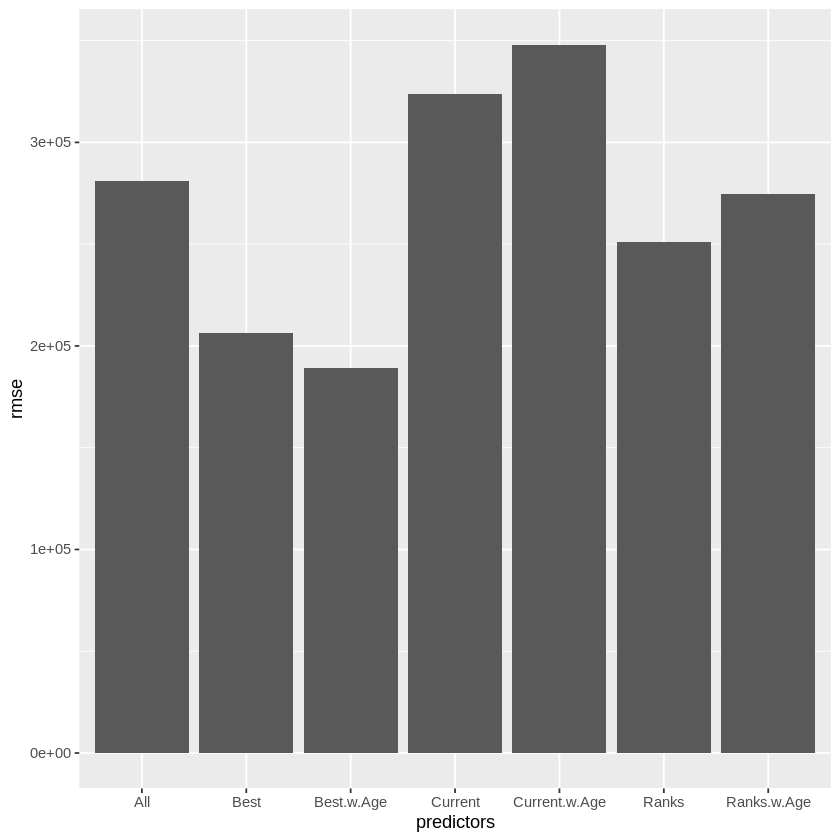

In [93]:
tennis_predictors_results <- tibble(predictors = c("Current", "Current.w.Age", "Best", "Best.w.Age",
                                                   "Ranks", "Ranks.w.Age", "All"),
                                 rmse = c(tennis_metric_current, tennis_metric_age,
                                          tennis_metric_best, tennis_metric_best_age,
                                          tennis_metric_ranks, tennis_metric_ranks_age,
                                          tennis_metric_all)) |>
arrange(rmse)
tennis_predictors_plot <- tennis_predictors_results |>
    ggplot(aes(x = predictors, y = rmse)) +
    geom_bar(stat = "identity")
tennis_predictors_results
tennis_predictors_plot